In [1]:
import pandas as pd
import numpy as np

# Assuming the CSV file is in the same directory as your script
file_path = 'D:\Downloads\ACTL5100\project\eda.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Now, df (DataFrame) is ready for data analytics.
# You can start analyzing your data using various pandas functionalities.
# For example, to get a summary of the dataframe:

# Add your data analysis code here

# Assuming df is your DataFrame

df = df.iloc[:,1:]

# Mapping "Policy.type" where "T20" is 0 and all other values are 1
df['Policy.type'] = df['Policy.type'].apply(lambda x: 0 if x == 'T20' else 1)

# Mapping "Sex" where "M" is 0 and all other values are 1
df['Sex'] = df['Sex'].apply(lambda x: 0 if x == 'M' else 1)

# Mapping "Urban.vs.Rural" where "Urban" is 0 and all other values are 1
df['Urban.vs.Rural'] = df['Urban.vs.Rural'].apply(lambda x: 0 if x == 'Urban' else 1)

# For "Smoker.Status", "Lapse.Indicator", and "Death.indicator" where NA is mapped to 0
# First, ensure that NA values are properly recognized as NaN
df.replace("NA", np.nan, inplace=True)

# Some cause of death are missing, convert them into string "Missing" to distinguish with survives
df.loc[(df['Death.indicator'] == 1) & (pd.isna(df['Cause.of.Death'])), 'Cause.of.Death'] = "Missing"

# Then, map "NS" to 0 and all other values to 1 for "Smoker.Status"
df['Smoker.Status'] = df['Smoker.Status'].apply(lambda x: 0 if x == 'NS' else 1)

# For "Lapse.Indicator", map NaN to 0 and all other values to 1
df['Lapse.Indicator'] = df['Lapse.Indicator'].apply(lambda x: 0 if pd.isna(x) else 1)

# For "Death.indicator", since it's a float, we assume NaN represents NA
# Map NaN to 0 and all other values to 1
df['Death.indicator'] = df['Death.indicator'].apply(lambda x: 0 if pd.isna(x) else 1)

df["Year.of.Exit"]=2023
df["Cause.of.Exit"]="Survive"

df.loc[(df['Death.indicator'] == 1) & (pd.isna(df['Cause.of.Death'])), 'Cause.of.Death'] = "Missing"

# Define conditions
conditions = [
    (df['Death.indicator'] == 1),  # Condition for death
    (df['Lapse.Indicator'] == 1)   # Condition for lapse
]

# Define choices corresponding to conditions
choices = [
    df['Cause.of.Death'],  # For death, use 'Cause.of.Death'
    "Lapse"                # For lapse, use the string "Lapse"
]

# Choices for "Year.of.Exit"
# Assuming 'Year.of.Death' and 'Year.of.Lapse' are the columns to use
choices_year = [
    df['Year.of.Death'],  # For death, use 'Year.of.Death'
    df['Year.of.Lapse']   # For lapse, use 'Year.of.Lapse'
]

# Default value for all other cases is "Survive"
df['Cause.of.Exit'] = np.select(conditions, choices, default='Survive')

# Apply conditions and choices for "Year.of.Exit"
df['Year.of.Exit'] = np.select(conditions, choices_year, default=2023)

df['Surv.Time'] = df['Year.of.Exit'] - df['Issue.year']

df['Exit.age'] = df['Issue.age'] + df['Surv.Time']

df['Death.indicator'] = df['Death.indicator']!=0
df['Lapse.Indicator'] = df['Lapse.Indicator']!=0


df_surv = df[df['Surv.Time']>0.01]


C:\Users\80693\AppData\Local\Temp\ipykernel_25788\624293353.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [34]:
# df.to_csv('data_by_py.csv', index=False)

In [2]:

# Display the first few rows to verify changes
print(df.head().T)
print(df.describe().T)
print(df.isnull().sum())
print(df.dtypes)


                                  0              1              2  \
Policy.type                       0              1              0   
Issue.year                     2001           2001           2001   
Issue.age                        54             54             27   
Sex                               1              0              1   
Face.amount                  100000        1000000          50000   
Smoker.Status                     0              0              0   
Underwriting.Class    moderate risk  moderate risk  very low risk   
Urban.vs.Rural                    0              1              0   
Region                            1              6              1   
Distribution.Channel   Telemarketer          Agent   Telemarketer   
Death.indicator               False          False          False   
Year.of.Death                   NaN            NaN            NaN   
Lapse.Indicator                True          False           True   
Year.of.Lapse                2020.

In [3]:
set(df["Cause.of.Death"])

{'A00-B99',
 'C00-D48',
 'D50-D89',
 'E00-E88',
 'F01-F99',
 'G00-G98',
 'I00-I99',
 'J00-J98',
 'K00-K92',
 'L00-L98',
 'M00-M99',
 'Missing',
 'N00-N98',
 'O00-O99',
 'Q00-Q99',
 'R00-R99',
 'V01-Y89',
 nan}

Text(0.5, 0, 'time $t$')

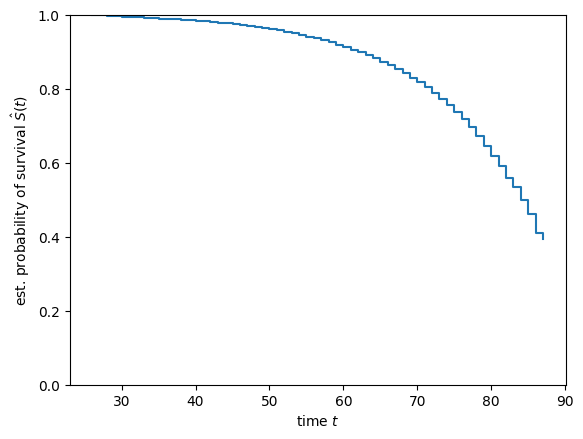

In [4]:

# import sweetviz
# my_report = sweetviz.analyze(df)
# my_report.show_html(filepath="D:\Downloads\ACTL5100\project\swreport.html",open_browser=True,layout="vertical",scale=1)

df_Death = df[df["Death.indicator"]==True]
df_Lapse = df[df["Lapse.Indicator"]==True]

In [13]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

def mortplot(pltdf):
    # plot survival function
    time, survival_prob= kaplan_meier_estimator(pltdf["Death.indicator"],pltdf["Exit.age"],pltdf["Issue.age"])
    plt.step(time, survival_prob, where="post")
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.title('S(x)')
    plt.show()
    # plot mortality function
    H = -np.log(survival_prob)
    plt.plot(time[:-1], H[1:]-H[:-1])
    plt.ylabel(r"est. mortality rate $\hat{h}(t)$")
    plt.xlabel("time $t$")
    plt.title('h(x)')
    plt.show()

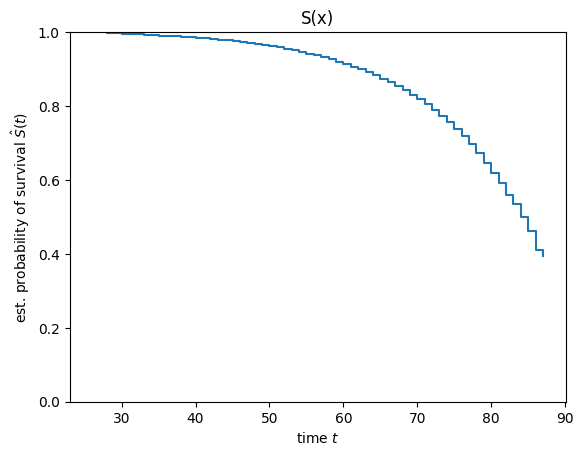

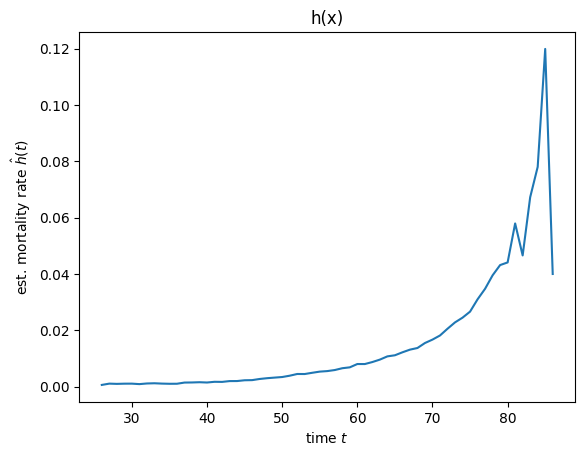

In [15]:
mortplot(df_surv)

In [24]:
def mortplot_comp(pltdf,cov):
    treatment_types = tuple(set(pltdf[cov]))
    for treatment_type in treatment_types:
        mask_treat = pltdf[cov] == treatment_type
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(
            pltdf["Death.indicator"][mask_treat],
            pltdf["Exit.age"][mask_treat],
            pltdf["Issue.age"][mask_treat],
        )

        plt.step(time_treatment, survival_prob_treatment, where="post", label=f"{cov} = {treatment_type}")
        

    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title('S(x)')
    plt.show()
    
    for treatment_type in treatment_types:
        mask_treat = pltdf[cov] == treatment_type
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(
            pltdf["Death.indicator"][mask_treat],
            pltdf["Exit.age"][mask_treat],
            pltdf["Issue.age"][mask_treat],
        )
        
        H = -np.log(survival_prob_treatment)
        plt.step(time_treatment[:-1], H[1:]-H[:-1], where="post", label=f"{cov} = {treatment_type}")
        
    plt.ylabel(r"est. mortality rate $\hat{h}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.title('h(x)')
    plt.show()
    
    

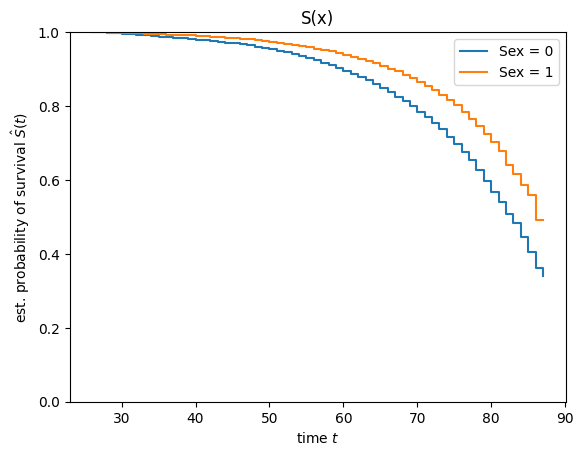

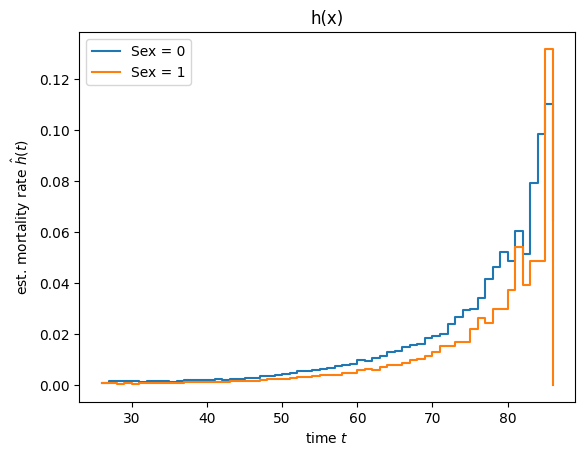

In [25]:
mortplot_comp(df_surv,"Sex")

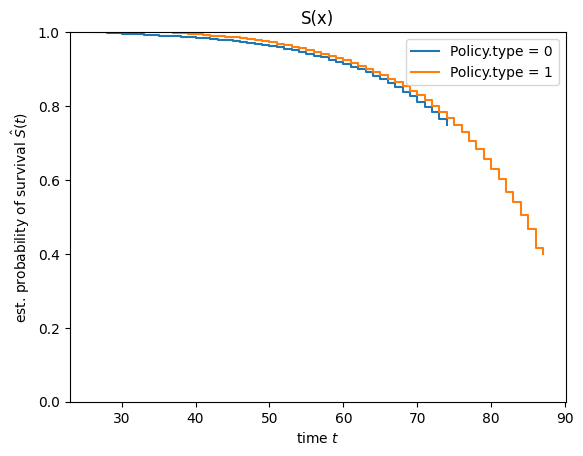

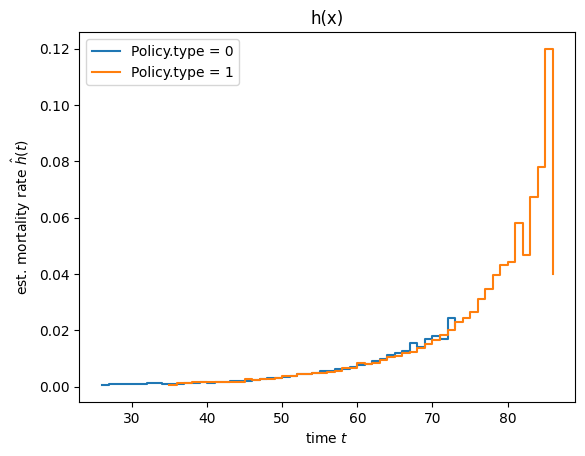

In [26]:
mortplot_comp(df_surv,"Policy.type")

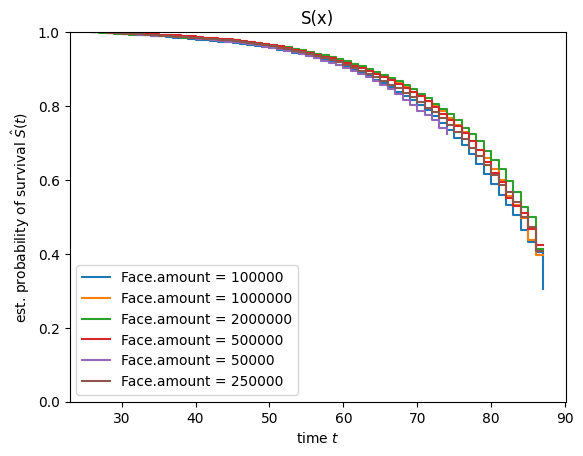

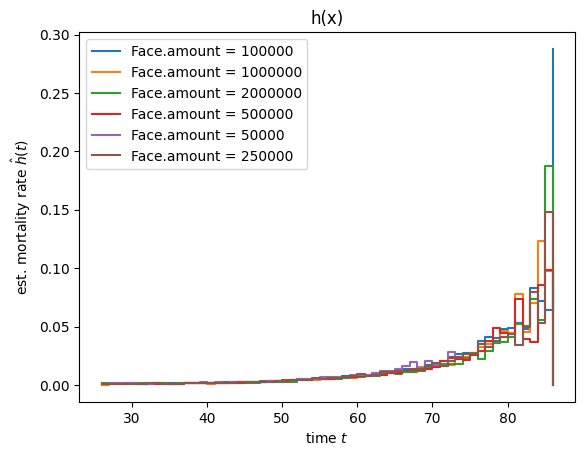

In [27]:
mortplot_comp(df_surv,"Face.amount")

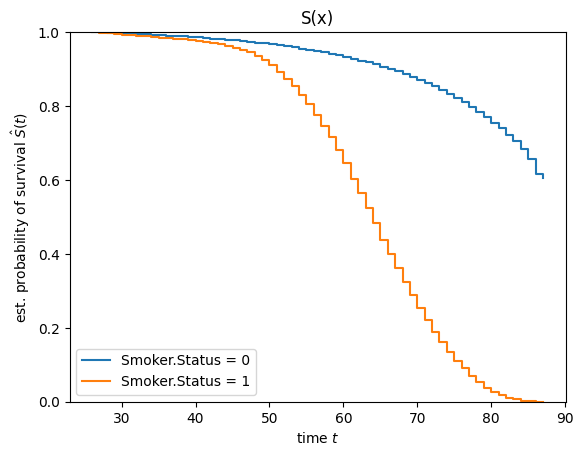

C:\Users\80693\AppData\Local\Temp\ipykernel_25788\1478379920.py:29: RuntimeWarning: divide by zero encountered in log
  H = -np.log(survival_prob_treatment)


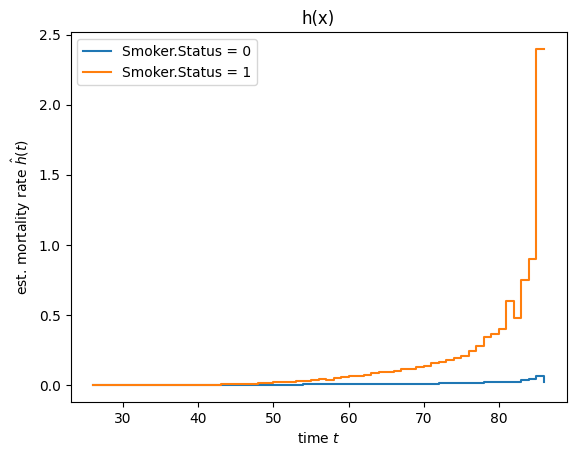

In [28]:
mortplot_comp(df_surv,"Smoker.Status")

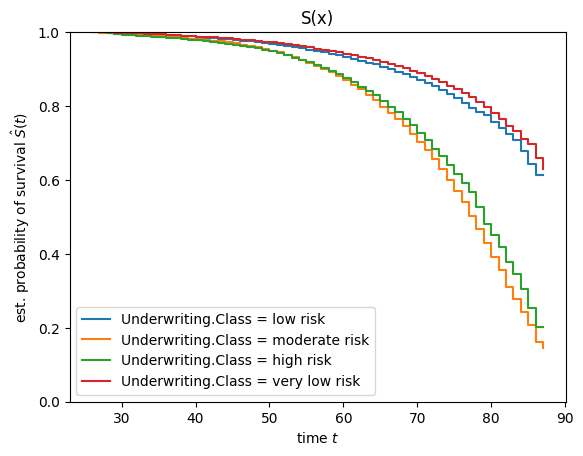

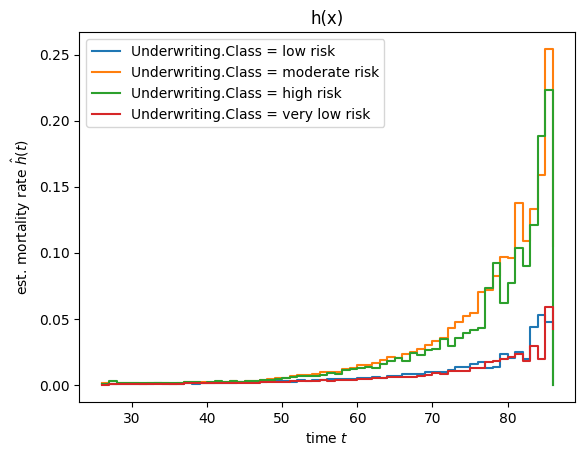

In [29]:
mortplot_comp(df_surv,"Underwriting.Class")

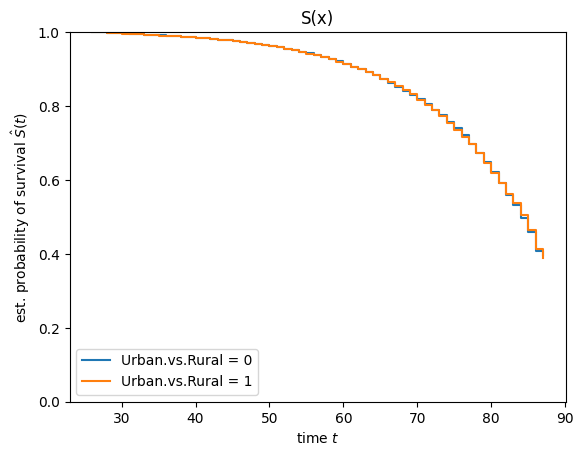

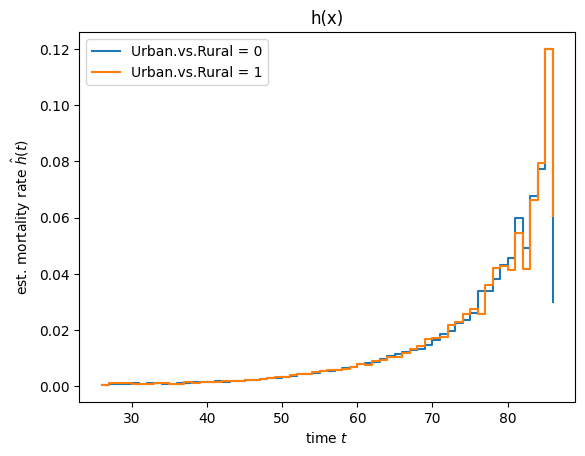

In [30]:
mortplot_comp(df_surv,"Urban.vs.Rural")

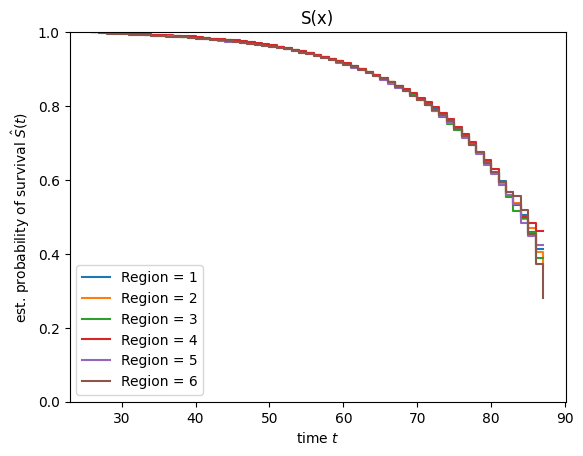

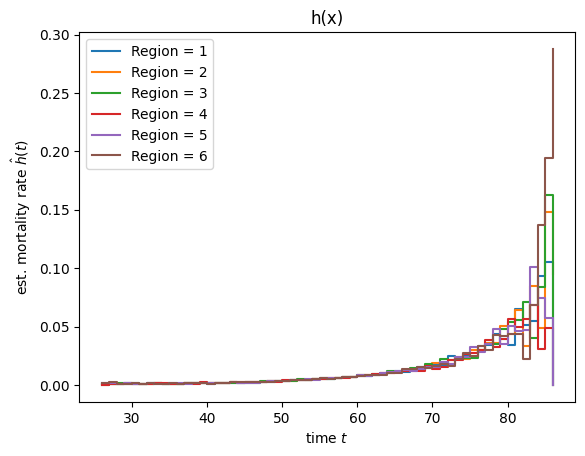

In [31]:
mortplot_comp(df_surv,"Region")

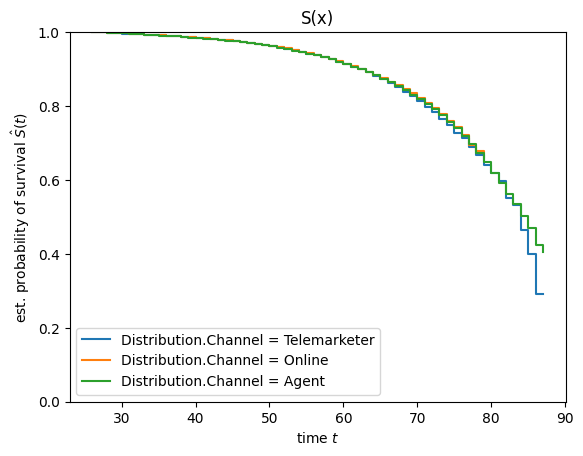

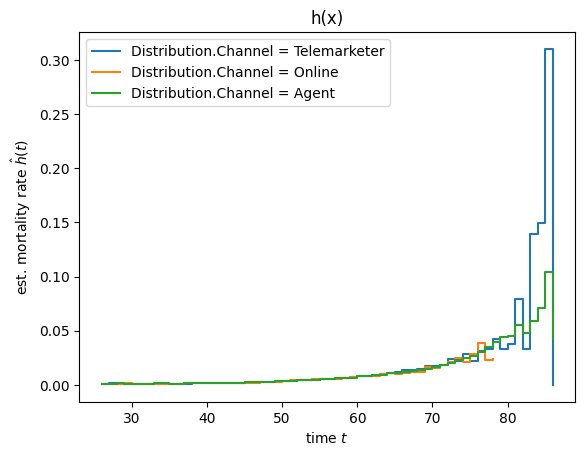

In [32]:
mortplot_comp(df_surv,"Distribution.Channel")